In [2]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx

plt.rcParams["text.usetex"] = True
colors = np.array(
    [
        [0.3647, 0.2824, 0.1059],
        [0.8549, 0.6314, 0.3294],
        [0.4745, 0.5843, 0.5373],
        [0.4745, 0.3843, 0.7373],
        [107.0 / 255, 42.0 / 255, 2.0 / 255],
    ]
)
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [20]:
d = 1
s = 1
pref = "BA" #f"d{d}s{s}"

path = "../Tests/Comparison_null_model"
path1 = f"../Tests/Experiments_simple/{pref}"
path2 = f"../Tests/Experiments_random/{pref}"

path1 = f"../Tests/Experiments_random/ER/deg_dist_simple.pkl"
path2 = f"../Tests/Experiments_random/ER/deg_dist.pkl"

with open(path1, "rb") as f:
    deg_dist_simple = pickle.load(f)


with open(path2, "rb") as f:
    deg_dist_random = pickle.load(f)

dim = support.list_dim(deg_dist_simple)
renorms = dim[1]
d = dim[3] 
n_tau = dim[2]
rep = dim[0]

dim2 = support.list_dim(deg_dist_random)
renorms2 = dim2[1]
d2 = dim2[3] 
n_tau2 = dim2[2]
rep2 = dim2[0]

In [19]:
dim

[5, 1, 30, 1]

In [21]:
def KS(deg1,deg2):
    test = scipy.stats.kstest(deg1, deg2)
    return test.statistic 

def mean_degree(deg1,deg2,d = 1):
    return np.mean(deg2)

def energy_degree(deg1,deg2, d = 1):
    return np.mean([d**2 for d in deg2])

def degree_variance(deg1,deg2, d = 1):
    return np.mean([d**2 for d in deg2])

def density(deg1,deg2,d = 1, degg = 0):
    N = len(deg2)
    
    maxedges = scipy.special.binom(N,scipy.special.binom(d+1,degg+1))
    return np.sum(deg2)/((d+1)*maxedges)

def JS(deg1,deg2,d = 1):
    dmax = int(max(np.max(deg1),np.max(deg2)))
    p1 = np.zeros(dmax+1)
    p2 = np.zeros(dmax+1)
    for i in deg1:
        p1[int(i)] += 1
    for i in deg2:
        p2[int(i)] += 1
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    p12 = 0.5 * (p1 + p2)
    jsd = 0.5 * (sp_entropy(p1, p12, base=2) + sp_entropy(p2, p12, base=2))
    return jsd

In [25]:
dim2

[10, 2, 50, 1]

In [35]:

measure = mean_degree

Ns_simple = np.zeros((rep, renorms, n_tau), dtype=int)
Ns_random = np.zeros((rep2, renorms2, n_tau2), dtype=int)

for r in range(rep):
    for i in range(renorms):
        for t in range(n_tau):
            Ns_simple[r, i, t] = len(deg_dist_simple[r][i][t][0])

for r in range(rep2):
    for i in range(renorms2):
        for t in range(n_tau2):
            Ns_random[r, i, t] = len(deg_dist_random[r][i][t][0])

deg_distance_simple = np.zeros((rep, renorms, d, n_tau))
deg_distance_random = np.zeros((rep2, renorms2, d2, n_tau2))

for r in range(rep):
    for norml in range(renorms):
        for degg in range(d):
            deg1s = deg_dist_simple[r][norml][0][degg]
            for tau in range(n_tau):
                deg2s = deg_dist_simple[r][norml][tau][degg]
                if len(deg2s) == 0:
                    deg2s = [0]
                deg_distance_simple[r, norml, degg, tau] = measure(deg1s,deg2s)

for r in range(rep2):
    for norml in range(renorms2):
        for degg in range(d2):
            deg1r = deg_dist_random[r][norml][0][degg]
            for tau in range(n_tau2):
                deg2r = deg_dist_random[r][norml][tau][degg]
                if len(deg2r) == 0:
                    deg2r = [0]
                deg_distance_random[r, norml, degg, tau] = measure(deg1r,deg2r)

Nsimp = Ns_simple[0,0,0]
Nrand = Ns_random[0,0,0]



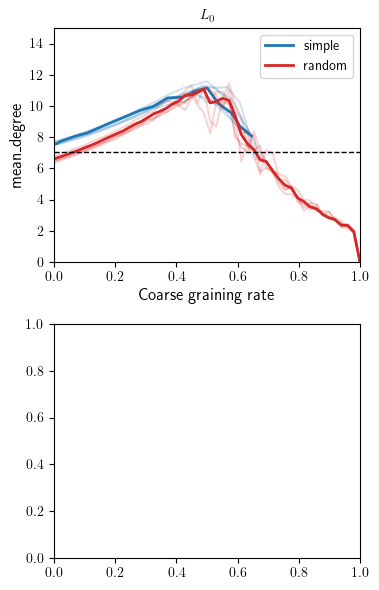

In [38]:

topp = [15,12]
logg = False
fig, axv = plt.subplots(d+1,d,figsize = (4*d,3*(d+1)))

for norml in range(d+1-1):
    for degg in range(d):
        if d == 1:
            ax1 = axv[norml]
        else:
            ax1 = axv[norml,degg]
        #ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Coarse graining rate')
        ax1.set_ylabel(measure.__name__)
        ax1.set_ylim(bottom = 0 ,top = topp[degg])
        ax1.set_xlim(0,1)
        if logg:
            #ax1.set_yscale('log')
            ax1.set_yscale('symlog',linthresh=0.000001)
        for r in range(rep):
                ax1.plot(1-Ns_simple[r,norml,:]/Nsimp, deg_distance_simple[r,norml,degg,:], color="tab:blue", alpha = 0.2)
        ax1.plot(1-np.median(Ns_simple[:,norml,:]/Nsimp,0), np.median(deg_distance_simple[:,norml,degg,:],0), color = "tab:blue", lw = 2, label = "simple")
        for r in range(rep):
                ax1.plot(1-Ns_random[r,norml,:]/Nrand, deg_distance_random[r,norml,degg,:], color="tab:red", alpha = 0.2)
        ax1.plot(1-np.median(Ns_random[:,norml,:]/Nrand,0), np.median(deg_distance_random[:,norml,degg,:],0), color = "tab:red", lw = 2, label = "random")
        ax1.legend()
        ax1.set_title(f"$L_{norml}$")
        if measure.__name__ in ["mean_degree", "degree_variance", "density","energy_degree"] :
            ax1.hlines((np.median(deg_distance_random[:,norml,degg,0])+np.median(deg_distance_simple[:,norml,degg,0]))/2, 0, 1, colors='black', lw = 1, linestyles='--')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/ER{d}_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")

In [40]:
from cycler import cycler
import powerlaw as pwl

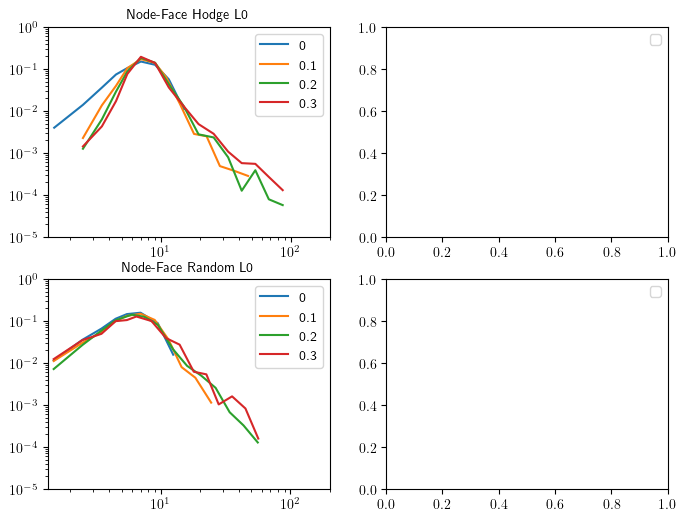

In [45]:
fig, axs  = plt.subplots(2,2,figsize = (8,6))

thr = [0,0.1,0.2,0.3]
norml = 0

r = 1
tau_simp0 = [0,0,0,0]
tau_simp1 = [0,0,0,0]

for t in range(len(thr)):
    tau_simp0[t] = np.argwhere(np.abs(1-Ns_simple[r,norml,:]/Nsimp)>=thr[t])[0,0]
    tau_simp1[t] = np.argwhere(np.abs(1-Ns_random[r,norml,:]/Nrand)>=thr[t])[0,0]


#new_colors = [plt.get_cmap('jet')(1. * i/10) for i in range(10)]
#plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist_simple[r][norml][tau_simp0[tau]][0][deg_dist_simple[r][norml][tau_simp0[tau]][0] != 0], ax = axs[0,0])
    axs[0,0].set_title(f"Node-Face Hodge L{norml}")
    axs[0,0].set_xlim(xmax = 200)
    axs[0,0].set_ylim(ymax = 1, ymin = 10**-5)
# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_simple[r][tau_simp0[tau]][norml][1][deg_dist_simple[r][tau_simp0[tau]][norml][1] != 0], ax = axs[0,1])
#     axs[0,1].set_title(f"Link-Face Hodge L{norml}")
#     axs[0,1].set_xlim(xmax = 40)
#     axs[0,1].set_ylim(ymax = 1, ymin = 10**-5)

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist_random[r][norml][tau_simp1[tau]][0][deg_dist_random[r][norml][tau_simp1[tau]][0] != 0], ax = axs[1,0])
    axs[1,0].set_title(f"Node-Face Random L{norml}")
    axs[1,0].set_xlim(xmax = 200)
    axs[1,0].set_ylim(ymax = 1, ymin = 10**-5)

# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_random[r][norml][tau_simp1[tau]][1][deg_dist_random[r][norml][tau_simp1[tau]][1] != 0], ax = axs[1,1])
#     axs[1,1].set_title(f"Link-Face Random L{norml}")
#     axs[1,1].set_xlim(xmax = 40)
#     axs[1,1].set_ylim(ymax = 1, ymin = 10**-5)

for i in range(2):
    for j in range(2):
        axs[i,j].legend(thr)
plt.savefig("../Tests/Comparison_null_model" + f"/{d}_deg_distributions_L{norml}ER.pdf", format="pdf")  # , bbox_inches="tight")

In [34]:
np.argwhere(1-Ns_simple[r,norml,:]/Nsimp >= 0.5)[0,0]

9

IndexError: index 1 is out of bounds for axis 1 with size 1

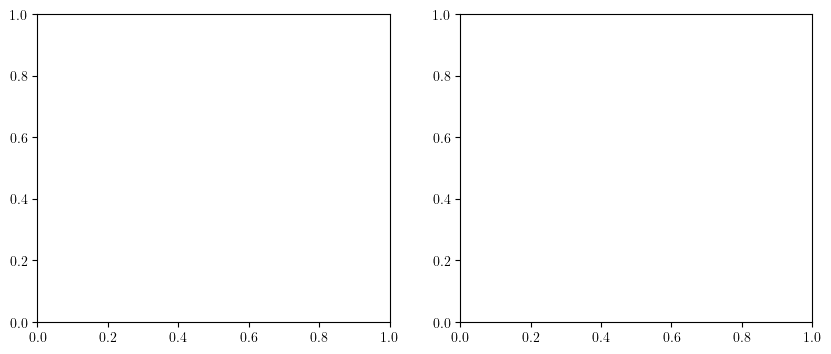

In [42]:
fig, axs  = plt.subplots(1,2,figsize = (10,4))

thr = [0,0.1,0.2,0.3,0.6]
norml = 1

r = 1
tau_simp0 = [0 for i in range(len(thr))]
tau_simp1 = [0 for i in range(len(thr))]

for t in range(len(thr)):
    tau_simp0[t] = np.argwhere(np.abs(1-Ns_simple[r,norml,:]/Nsimp)>=thr[t])[0,0]
    tau_simp1[t] = np.argwhere(np.abs(1-Ns_random[r,norml,:]/Nrand)>=thr[t])[0,0]


new_colors = [plt.get_cmap('jet')(1. * i/10) for i in range(10)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist_simple[r][tau_simp0[tau]][norml][0][deg_dist_simple[r][tau_simp0[tau]][norml][0] != 0], ax = axs[0])
    axs[0].set_title(f"Node-Link Hodge L{norml}")
    axs[0].set_xlim(xmax = 100)
    axs[0].set_ylim(ymin = 10**-5)

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist_random[r][norml][tau_simp1[tau]][0][deg_dist_random[r][norml][tau_simp1[tau]][0] != 0], ax = axs[1])
    axs[1].set_title(f"Node-Link Random L{norml}")
    axs[1].set_xlim(xmax = 100)
    axs[1].set_ylim(ymin = 10**-5)   

for i in range(1):
    for j in range(2):
        axs[j].legend(thr)
plt.savefig("../Tests/Comparison_null_model" + f"/dim{d}deg_distributions_L{norml}.pdf", format="pdf")  # , bbox_inches="tight")